<a href="https://colab.research.google.com/github/SoRu17/DataScience2/blob/main/An%C3%A1lisis_de_Tendencias_Clim%C3%A1ticas_y_su_Impacto_Sof%C3%ADa_Bel%C3%A9n_Ruibal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science 2 (2025)

# "Análisis de Tendencias Climáticas y su Impacto"

# Sofía Belén Ruibal

# Profesor: Joaquín Salas

# **Introducción**


**Este proyecto de análisis exploratorio (EDA) y simulación busca comprender y cuantificar la relación entre las variables climáticas y los patrones de venta de productos específicos en el barrio de Belgrano, Ciudad de Buenos Aires.**

**Para la obtención de datos climáticos que nos permitieron realizar este análisis, hemos utilizado la API (Interfaz de Programación de Aplicaciones) de OpenWeatherMap.**

**Información Clave de la API y Datos Climáticos Recopilados:**

**Proveedor de la API: OpenWeatherMap
Página Oficial de la API: https://openweathermap.org/api
Ubicación de Consulta: Barrio de Belgrano, Ciudad de Buenos Aires. Se utilizó un identificador geográfico (como el ID de la ciudad para Buenos Aires) para asegurar la relevancia local de los datos.
Período de Datos: Los datos históricos analizados abarcan 365 días con intervalos por hora, sumando un total de 8.760 registros individuales.
Variables Climáticas Consultadas:
Temperatura (°C): Fundamental para comprender la demanda de helados y bebidas calientes.**

**Precipitación (mm): Clave para analizar el impacto en las ventas de paraguas y hielo.**

**Humedad (%): Explorada por su posible correlación con el bienestar y el consumo de ciertos productos.
Velocidad del Viento (m/s): Incluida para evaluar su influencia, aunque en el análisis se encontró una correlación más débil.**

# Extracción y recopilacion de datos


In [1]:
import datetime as dt



# --- Configuración Global de Fechas para todo el proyecto ---

# Definir el rango de fechas para los últimos 365 días hasta hoy

end_date_global = dt.datetime.now(dt.timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

start_date_global = end_date_global - dt.timedelta(days=365)



print(f"Rango de Fechas Global del Proyecto (UTC):")

print(f"  Inicio: {start_date_global}")

print(f"  Fin:    {end_date_global}")





# from google.colab import userdata

# OPENWEATHER_API_KEY = userdata.get('OPENWEATHER_API_KEY')

Rango de Fechas Global del Proyecto (UTC):
  Inicio: 2024-08-02 00:00:00+00:00
  Fin:    2025-08-02 00:00:00+00:00


In [2]:
from google.colab import userdata
import requests
import pandas as pd
import json
import datetime as dt
import numpy as np

# Carga de la API Key desde Colab Secrets
API_KEY = userdata.get('OPENWEATHER_API_KEY')

if API_KEY:
    print("API Key cargada correctamente desde Colab Secrets.")
else:
    print("Error: La API Key no pudo ser cargada. Asegúrate de haberla guardado en Colab Secrets con el nombre correcto y tener el acceso del notebook activado.")

# --- Código para hacer la consulta a la API de OpenWeatherMap (Clima Actual) ---
# Usaré "Belgrano" para la consulta de clima actual genérica, aunque la API de 2.5 quizás no lo reconozca como ciudad.

CITY_NAME = 'Belgrano'
COUNTRY_CODE = 'AR'
current_weather_url = f"http://api.openweathermap.org/data/2.5/weather?q={CITY_NAME},{COUNTRY_CODE}&appid={API_KEY}&units=metric&lang=es"

try:
    response = requests.get(current_weather_url)
    response.raise_for_status()
    current_weather_data = response.json()


    print(f"\nClima actual en {CITY_NAME}:") # <-- CAMBIO AQUÍ
    print(f"  Temperatura: {current_weather_data['main']['temp']} °C")
    print(f"  Sensación térmica: {current_weather_data['main']['feels_like']} °C")
    print(f"  Humedad: {current_weather_data['main']['humidity']}%")
    print(f"  Descripción: {current_weather_data['weather'][0]['description'].capitalize()}")
    print(f"  Velocidad del viento: {current_weather_data['wind']['speed']} m/s")

except requests.exceptions.HTTPError as http_err:
    print(f"Error HTTP: {http_err} - Revisar la API Key o el nombre de la localidad ('Belgrano' podría no ser reconocido como ciudad principal por la API 2.5).")
    print("Para el clima actual, puede ser necesario usar 'Buenos Aires' si 'Belgrano' no es reconocido.")
except requests.exceptions.ConnectionError as conn_err:
    print(f"Error de conexión: {conn_err} - Revisar conexión a internet.")
except requests.exceptions.Timeout as timeout_err:
    print(f"Tiempo de espera agotado: {timeout_err} - El servidor no respondió a tiempo.")
except requests.exceptions.RequestException as req_err:
    print(f"Otro error: {req_err}")
except KeyError as k_err:
    print(f"Error al parsear la respuesta (KeyError): {k_err} - La estructura de la respuesta no es la esperada. Posiblemente la localidad no fue encontrada.")
    print(f"Respuesta completa (para depuración): {current_weather_data}")

API Key cargada correctamente desde Colab Secrets.

Clima actual en Belgrano:
  Temperatura: 15.18 °C
  Sensación térmica: 14.74 °C
  Humedad: 76%
  Descripción: Cielo claro
  Velocidad del viento: 2.06 m/s


#  Obtención de datos climáticos históricos

In [3]:
import requests
import pandas as pd
import datetime as dt

# --- Coordenadas de BELGRANO, Ciudad de Buenos Aires ---
lat = -34.540522  # Latitud de Belgrano
lon = -58.451439 # Longitud de Belgrano

# --- Fechas para los datos históricos (ÚLTIMOS 365 DÍAS) ---
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=365)


# --- Endpoint de Open-Meteo para datos históricos ---
open_meteo_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,weathercode"
    f"&timezone=America%2FArgentina%2FBuenos_Aires"
)

# Diccionario para mapear weathercode a descripciones
weather_codes = {
    0: 'Cielo Despejado', 1: 'Mayormente Despejado', 2: 'Parcialmente Nublado', 3: 'Nublado',
    45: 'Niebla', 48: 'Niebla Escarchada', 51: 'Llovizna Ligera', 53: 'Llovizna Moderada',
    55: 'Llovizna Densa', 56: 'Llovizna Helada Ligera', 57: 'Llovizna Helada Densa',
    61: 'Lluvia Ligera', 63: 'Lluvia Moderada', 65: 'Lluvia Intensa', 66: 'Lluvia Helada Ligera',
    67: 'Lluvia Helada Intensa', 71: 'Nevada Ligera', 73: 'Nevada Moderada', 75: 'Nevada Intensa',
    77: 'Granizo', 80: 'Chubascos Ligeros', 81: 'Chubascos Moderados', 82: 'Chubascos Violentos',
    85: 'Nevadas Ligeras', 86: 'Nevadas Intensas', 95: 'Tormenta Ligera/Moderada',
    96: 'Tormenta con Granizo Ligero', 99: 'Tormenta con Granizo Intenso'
}

print(f"\n--- Obteniendo datos históricos de Open-Meteo para EL BARRIO DE BELGRANO ({start_date} a {end_date}) ---") # <-- CAMBIO AQUÍ

try:
    response = requests.get(open_meteo_url)
    response.raise_for_status()
    open_meteo_data = response.json()

    hourly_data = open_meteo_data['hourly']
    df_historical_weather = pd.DataFrame(hourly_data)

    df_historical_weather.rename(columns={
        'time': 'Fecha_Hora_UTC', 'temperature_2m': 'Temperatura_C',
        'relative_humidity_2m': 'Humedad_Porcentaje', 'precipitation': 'Precipitacion_mm',
        'wind_speed_10m': 'Velocidad_Viento_ms', 'weathercode': 'Codigo_Clima'
    }, inplace=True)

    df_historical_weather['Fecha_Hora_UTC'] = pd.to_datetime(df_historical_weather['Fecha_Hora_UTC'], utc=True)
    df_historical_weather.set_index('Fecha_Hora_UTC', inplace=True)

    df_historical_weather['Descripcion_Clima'] = df_historical_weather['Codigo_Clima'].map(weather_codes).fillna('Desconocido')

    print("\nDataFrame de datos históricos de Open-Meteo para EL BARRIO DE BELGRANO creado:") # <-- CAMBIO AQUÍ
    print(df_historical_weather.head())
    print("\nInformación detallada del DataFrame de clima histórico:")
    df_historical_weather.info()
    print(f"\nTotal de registros históricos: {len(df_historical_weather)}")
    print(f"Rango de fechas obtenido: Desde {df_historical_weather.index.min()} hasta {df_historical_weather.index.max()}")

    df_historical_weather.to_csv('datos_climaticos_historicos_belgrano.csv', index=True)
    print("\nDatos históricos guardados en 'datos_climaticos_historicos_belgrano.csv'")

except requests.exceptions.RequestException as e:
    print(f"Error al obtener datos históricos de Open-Meteo: {e}")
    if 'response' in locals() and response.status_code:
        print(f"Código de estado HTTP: {response.status_code}")
        print(f"Mensaje de error de la API: {response.text}")
    print("Asegúrate de que la URL de la API de Open-Meteo sea correcta y que tus coordenadas sean válidas.")
except KeyError as e:
    print(f"Error al procesar la respuesta de Open-Meteo (KeyError): {e}")
    print("La estructura de la respuesta no es la esperada. Imprimiendo respuesta completa para depuración:")
    if 'open_meteo_data' in locals():
        print(json.dumps(open_meteo_data, indent=2))
    else:
        print("La variable 'open_meteo_data' no está definida, no se pudo obtener la respuesta JSON.")


--- Obteniendo datos históricos de Open-Meteo para EL BARRIO DE BELGRANO (2024-08-02 a 2025-08-02) ---

DataFrame de datos históricos de Open-Meteo para EL BARRIO DE BELGRANO creado:
                           Temperatura_C  Humedad_Porcentaje  \
Fecha_Hora_UTC                                                 
2024-08-02 00:00:00+00:00           21.6                65.0   
2024-08-02 01:00:00+00:00           21.7                64.0   
2024-08-02 02:00:00+00:00           21.7                63.0   
2024-08-02 03:00:00+00:00           21.7                62.0   
2024-08-02 04:00:00+00:00           21.5                62.0   

                           Precipitacion_mm  Velocidad_Viento_ms  \
Fecha_Hora_UTC                                                     
2024-08-02 00:00:00+00:00               0.0                 31.1   
2024-08-02 01:00:00+00:00               0.0                 33.0   
2024-08-02 02:00:00+00:00               0.0                 35.9   
2024-08-02 03:00:00+00:00  

In [4]:
import pandas as pd

# Nombre del archivo CSV
nombre_archivo = 'datos_climaticos_historicos_belgrano.csv'

# Leer el archivo CSV en un DataFrame
try:
    df_desde_csv = pd.read_csv(nombre_archivo, index_col=0)

    print(f"\n--- DataFrame cargado desde '{nombre_archivo}' ---")
    print(df_desde_csv.head())
    print(f"Total de registros cargados: {len(df_desde_csv)}")
    print("Columnas:", df_desde_csv.columns.tolist())

except FileNotFoundError:
    print(f"Error: El archivo '{nombre_archivo}' no fue encontrado. Asegúrate de haber ejecutado la celda anterior para crearlo.")
except Exception as e:
    print(f"Ocurrió un error al leer el archivo CSV: {e}")


--- DataFrame cargado desde 'datos_climaticos_historicos_belgrano.csv' ---
                           Temperatura_C  Humedad_Porcentaje  \
Fecha_Hora_UTC                                                 
2024-08-02 00:00:00+00:00           21.6                65.0   
2024-08-02 01:00:00+00:00           21.7                64.0   
2024-08-02 02:00:00+00:00           21.7                63.0   
2024-08-02 03:00:00+00:00           21.7                62.0   
2024-08-02 04:00:00+00:00           21.5                62.0   

                           Precipitacion_mm  Velocidad_Viento_ms  \
Fecha_Hora_UTC                                                     
2024-08-02 00:00:00+00:00               0.0                 31.1   
2024-08-02 01:00:00+00:00               0.0                 33.0   
2024-08-02 02:00:00+00:00               0.0                 35.9   
2024-08-02 03:00:00+00:00               0.0                 36.3   
2024-08-02 04:00:00+00:00               0.0                 35.1   

In [5]:
df_desde_csv.describe()


,Temperatura_C,Humedad_Porcentaje,Precipitacion_mm,Velocidad_Viento_ms,Codigo_Clima
count,8734.000000,8734.000000,8734.000000,8734.000000,8734.000000
mean,18.005507,72.372452,0.135219,13.161575,6.520953
std,6.443723,15.722398,0.801568,6.327472,16.106196
min,-0.700000,19.000000,0.000000,0.000000,0.000000
25%,13.000000,63.000000,0.000000,8.800000,0.000000
50%,18.300000,75.000000,0.000000,12.400000,1.000000
75%,22.800000,85.000000,0.000000,16.700000,3.000000
max,37.600000,100.000000,22.000000,41.600000,75.000000


In [6]:
df_desde_csv.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 2024-08-02 00:00:00+00:00 to 2025-08-02 23:00:00+00:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temperatura_C        8734 non-null   float64
 1   Humedad_Porcentaje   8734 non-null   float64
 2   Precipitacion_mm     8734 non-null   float64
 3   Velocidad_Viento_ms  8734 non-null   float64
 4   Codigo_Clima         8734 non-null   float64
 5   Descripcion_Clima    8784 non-null   object 
dtypes: float64(5), object(1)
memory usage: 480.4+ KB


In [7]:
df_desde_csv.head(100)

,Temperatura_C,Humedad_Porcentaje,Precipitacion_mm,Velocidad_Viento_ms,Codigo_Clima,Descripcion_Clima
Fecha_Hora_UTC,,,,,,
2024-08-02 00:00:00+00:00,21.6,65.0,0.0,31.1,3.0,Nublado
2024-08-02 01:00:00+00:00,21.7,64.0,0.0,33.0,3.0,Nublado
2024-08-02 02:00:00+00:00,21.7,63.0,0.0,35.9,3.0,Nublado
2024-08-02 03:00:00+00:00,21.7,62.0,0.0,36.3,3.0,Nublado
2024-08-02 04:00:00+00:00,21.5,62.0,0.0,35.1,3.0,Nublado
...,...,...,...,...,...,...
2024-08-05 23:00:00+00:00,15.2,95.0,0.0,11.6,3.0,Nublado
2024-08-06 00:00:00+00:00,15.4,95.0,0.0,10.5,3.0,Nublado
2024-08-06 01:00:00+00:00,15.3,96.0,0.0,10.1,3.0,Nublado


# Simulación de datos de ventas para el barrio de Belgrano, Ciudad Autónoma de Buenos Aires

In [8]:
import datetime as dt
import numpy as np
import pandas as pd

print("\n--- Iniciando el Paso 3: Simulación de Datos de Ventas para EL BARRIO DE BELGRANO ---")

# --- Usar las fechas globales definidas en la Celda 1 ---
# Asegurarse de que el rango de fechas de simulación coincida exactamente
# y que las horas sean exactas en el segundo 0.
# Ajuste para que empiece en la hora 00:00:00 del start_date_global
# y termine en la hora 00:00:00 del end_date_global.
# El freq='H' generará timestamps como 00:00:00, 01:00:00, etc.
date_range_sales = pd.date_range(start=start_date_global.replace(minute=0, second=0, microsecond=0),
                                 end=end_date_global.replace(minute=0, second=0, microsecond=0), # Asegura que termina en la hora 00
                                 freq='H',
                                 tz=dt.timezone.utc)

sales_data_sim = []
for current_time in date_range_sales:
    # Simulación de temperatura y precipitación para dar lógica a las ventas ficticias
    simulated_temp_for_sales = 15 + 10 * np.sin(current_time.dayofyear * 2 * np.pi / 365) + 5 * np.random.randn()
    if simulated_temp_for_sales < -5: simulated_temp_for_sales = -5
    if simulated_temp_for_sales > 35: simulated_temp_for_sales = 35

    simulated_precipitation_for_sales = 0
    if np.random.rand() < 0.25:
        simulated_precipitation_for_sales = max(0, np.random.normal(2, 4))

    # Venta de HELADOS (mayor venta con mayor temperatura, afectado por lluvia)
    base_sales_helados = 50
    factor_temp_helados = 4
    sales_helados = max(0.0, base_sales_helados + (simulated_temp_for_sales - 15) * factor_temp_helados + np.random.normal(0, 15))
    if simulated_precipitation_for_sales > 1:
        sales_helados *= 0.6

    # Venta de BEBIDAS CALIENTES (mayor venta con menor temperatura, puede aumentar con lluvia)
    base_sales_bebidas_calientes = 60
    factor_temp_bebidas_calientes = 3
    sales_bebidas_calientes = max(0.0, base_sales_bebidas_calientes + (15 - simulated_temp_for_sales) * factor_temp_bebidas_calientes + np.random.normal(0, 10))
    if simulated_precipitation_for_sales > 0:
        sales_bebidas_calientes *= 1.1

    # Venta de HIELO (mayor venta con mayor temperatura, afectado por lluvia)
    base_sales_hielo = 20
    factor_temp_hielo = 2
    sales_hielo = max(0.0, base_sales_hielo + (simulated_temp_for_sales - 15) * factor_temp_hielo + np.random.normal(0, 5))
    if simulated_precipitation_for_sales > 1:
        sales_hielo *= 0.7

    # Venta de PARAGUAS (mayor venta con precipitación)
    base_sales_paraguas = 5
    factor_precip_paraguas = 10
    sales_paraguas = max(0.0, base_sales_paraguas + simulated_precipitation_for_sales * factor_precip_paraguas + np.random.normal(0, 3))
    if simulated_precipitation_for_sales > 5:
        sales_paraguas *= 1.5

    sales_data_sim.append({
        'Fecha_Hora_UTC': current_time, # current_time ya viene en el formato exacto de la hora sin microsegundos
        'Ventas_Helados': int(round(sales_helados)),
        'Ventas_Bebidas_Calientes': int(round(sales_bebidas_calientes)),
        'Ventas_Hielo': int(round(sales_hielo)),
        'Ventas_Paraguas': int(round(sales_paraguas))
    })

df_sales_simulated = pd.DataFrame(sales_data_sim)
df_sales_simulated.set_index('Fecha_Hora_UTC', inplace=True)

print("\nDataFrame de ventas simuladas para EL BARRIO DE BELGRANO creado:")
print(df_sales_simulated.head())
print(f"Total de registros de ventas simuladas: {len(df_sales_simulated)}")
print(f"Rango de Fechas df_sales_simulated: {df_sales_simulated.index.min()} a {df_sales_simulated.index.max()}")
print(f"Tipo de índice df_sales_simulated: {df_sales_simulated.index.dtype}")
print(f"Zona horaria del índice df_sales_simulated: {df_sales_simulated.index.tz}")

print("\nVerificación de valores de ventas simuladas:")
for col in ['Ventas_Helados', 'Ventas_Bebidas_Calientes', 'Ventas_Hielo', 'Ventas_Paraguas']:
    print(f"  {col}: Min={df_sales_simulated[col].min()}, Max={df_sales_simulated[col].max()}, Media={df_sales_simulated[col].mean():.2f}")

df_sales_simulated.to_csv('datos_ventas_simuladas_belgrano.csv', index=True)
print("Datos de ventas simuladas guardados en 'datos_ventas_simuladas_belgrano.csv'")


--- Iniciando el Paso 3: Simulación de Datos de Ventas para EL BARRIO DE BELGRANO ---


/tmp/ipython-input-1200244665.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range_sales = pd.date_range(start=start_date_global.replace(minute=0, second=0, microsecond=0),



DataFrame de ventas simuladas para EL BARRIO DE BELGRANO creado:
                           Ventas_Helados  Ventas_Bebidas_Calientes  \
Fecha_Hora_UTC                                                        
2024-08-02 00:00:00+00:00              13                        78   
2024-08-02 01:00:00+00:00              44                        72   
2024-08-02 02:00:00+00:00               3                        92   
2024-08-02 03:00:00+00:00              67                        53   
2024-08-02 04:00:00+00:00              16                        65   

                           Ventas_Hielo  Ventas_Paraguas  
Fecha_Hora_UTC                                            
2024-08-02 00:00:00+00:00             8                7  
2024-08-02 01:00:00+00:00            16                3  
2024-08-02 02:00:00+00:00             0                4  
2024-08-02 03:00:00+00:00            15                3  
2024-08-02 04:00:00+00:00            10              112  
Total de registros de v

In [9]:
# Mostrar las primeras filas del DataFrame de ventas simuladas
print("\nCuadro de las primeras filas del DataFrame de ventas simuladas:")
print(df_sales_simulated.head())


Cuadro de las primeras filas del DataFrame de ventas simuladas:
                           Ventas_Helados  Ventas_Bebidas_Calientes  \
Fecha_Hora_UTC                                                        
2024-08-02 00:00:00+00:00              13                        78   
2024-08-02 01:00:00+00:00              44                        72   
2024-08-02 02:00:00+00:00               3                        92   
2024-08-02 03:00:00+00:00              67                        53   
2024-08-02 04:00:00+00:00              16                        65   

                           Ventas_Hielo  Ventas_Paraguas  
Fecha_Hora_UTC                                            
2024-08-02 00:00:00+00:00             8                7  
2024-08-02 01:00:00+00:00            16                3  
2024-08-02 02:00:00+00:00             0                4  
2024-08-02 03:00:00+00:00            15                3  
2024-08-02 04:00:00+00:00            10              112  


# Combinación y Limpieza de Datos. Data Wrangling

In [10]:
import pandas as pd
import datetime as dt # Asegurar de que datetime esté importado si no lo está en celdas anteriores

print("\n--- Combinación y Limpieza de Datos para EL BARRIO DE BELGRANO ---")

# --- 1. Cargar los datos guardados de los pasos anteriores (desde CSVs) ---
try:
    df_clima_hist = pd.read_csv('datos_climaticos_historicos_belgrano.csv', parse_dates=['Fecha_Hora_UTC'], index_col='Fecha_Hora_UTC')
    df_ventas_sim = pd.read_csv('datos_ventas_simuladas_belgrano.csv', parse_dates=['Fecha_Hora_UTC'], index_col='Fecha_Hora_UTC')
    print("Archivos CSV de clima y ventas cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error al cargar los archivos: {e}.")
    print("Asegúrate de que los CSVs 'datos_climaticos_historicos_belgrano.csv' y 'datos_ventas_simuladas_belgrano.csv' existan en tu entorno de Colab.")
    print("Por favor, asegúrate de haber ejecutado las Celdas 2 y 3 previamente.")
    exit() # Sale del script si los archivos no se encuentran

# --- 2. Asegurarse de que los índices estén en UTC y sean del mismo tipo ---
# Esto es crucial para una unión correcta y para evitar errores de alineación de tiempo.
df_clima_hist.index = pd.to_datetime(df_clima_hist.index, utc=True)
df_ventas_sim.index = pd.to_datetime(df_ventas_sim.index, utc=True)

print(f"\nRangos de fechas de los DataFrames antes de la unión:")
print(f"  Clima: {df_clima_hist.index.min()} a {df_clima_hist.index.max()}")
print(f"  Ventas: {df_ventas_sim.index.min()} a {df_ventas_sim.index.max()}")


# --- 3. Unir los DataFrames por el índice de fecha/hora ---
# Usamos how='inner' para asegurar que solo se incluyan las filas donde hay datos de clima Y ventas para la misma hora.
# Esto es útil si los rangos de fechas o la granularidad no fueran exactamente iguales.
df_combined_belgrano = pd.merge(df_clima_hist, df_ventas_sim, left_index=True, right_index=True, how='inner')

print(f"\nDataFrame combinado creado. Total de registros después de la unión: {len(df_combined_belgrano)}")
print(f"Nuevo rango de fechas del DataFrame combinado: {df_combined_belgrano.index.min()} a {df_combined_belgrano.index.max()}")


# --- 4. Limpieza y Transformación Adicionales ---

# Eliminar duplicados si los hubiera (basado en el índice y todas las columnas)
initial_rows = len(df_combined_belgrano)
df_combined_belgrano.drop_duplicates(inplace=True)
if len(df_combined_belgrano) < initial_rows:
    print(f"Se eliminaron {initial_rows - len(df_combined_belgrano)} filas duplicadas.")
else:
    print("No se encontraron filas duplicadas.")


# Renombrar columnas para mayor claridad y consistencia (ajustado a las variables que usamos)
df_combined_belgrano.rename(columns={
    'Temperatura_C': 'Temperatura', # Renombramos para simplificar 'Temperatura_C' a 'Temperatura'
    'Humedad_Porcentaje': 'Humedad',
    'Velocidad_Viento_ms': 'Viento_ms',
    'Descripcion_Clima': 'Clima_Detallado' # Esta columna ya se genera en el paso de Open-Meteo
}, inplace=True)

print("\nColumnas renombradas para mayor claridad.")


# --- 5. Crear nuevas columnas (Feature Engineering) ---
# Extraer el día de la semana y la hora del día del índice de fecha/hora.
# Esto puede ser útil para análisis futuros sobre patrones diarios o semanales.
df_combined_belgrano['Dia_Semana'] = df_combined_belgrano.index.day_name()
df_combined_belgrano['Hora_del_Dia'] = df_combined_belgrano.index.hour

print("\nNuevas columnas 'Dia_Semana' y 'Hora_del_Dia' creadas.")


# --- 6. Mostrar un resumen del DataFrame combinado y limpiado ---
print("\n--- Resumen del DataFrame final combinado y limpiado para EL BARRIO DE BELGRANO ---")
print("Información detallada del DataFrame:")
df_combined_belgrano.info()

print("\nPrimeras 5 filas del DataFrame:")
print(df_combined_belgrano.head())

print("\nEstadísticas descriptivas de las columnas numéricas:")
print(df_combined_belgrano.describe())

# --- 7. Guardar el DataFrame combinado y limpio en un nuevo CSV ---

df_combined_belgrano.to_csv('datos_analisis_belgrano.csv', index=True)
print("\nDataFrame combinado y limpio guardado exitosamente en 'datos_analisis_belgrano.csv'")

print("\n--- Combinación y Limpieza de Datos COMPLETADO ---")


--- Combinación y Limpieza de Datos para EL BARRIO DE BELGRANO ---
Archivos CSV de clima y ventas cargados exitosamente.

Rangos de fechas de los DataFrames antes de la unión:
  Clima: 2024-08-02 00:00:00+00:00 a 2025-08-02 23:00:00+00:00
  Ventas: 2024-08-02 00:00:00+00:00 a 2025-08-02 00:00:00+00:00

DataFrame combinado creado. Total de registros después de la unión: 8761
Nuevo rango de fechas del DataFrame combinado: 2024-08-02 00:00:00+00:00 a 2025-08-02 00:00:00+00:00
No se encontraron filas duplicadas.

Columnas renombradas para mayor claridad.

Nuevas columnas 'Dia_Semana' y 'Hora_del_Dia' creadas.

--- Resumen del DataFrame final combinado y limpiado para EL BARRIO DE BELGRANO ---
Información detallada del DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2024-08-02 00:00:00+00:00 to 2025-08-02 00:00:00+00:00
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  

# Análisis Exploratorio de Datos (EDA)

0. Configuración Inicial y Carga de Datos

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Iniciando el Paso 5: Análisis por Pregunta / Hipótesis ---")

# --- Definición de la paleta de colores sugerida (TONOS SUAVES) ---
colors = {
    'general_text': '#4F4F4F', # Gris oscuro suave para texto general
    'background_light': '#FDFDFD', # Blanco casi puro para fondos de gráficos
    'blue_main': '#7DA0B1',      # Azul suave y profesional
    'orange_accent': '#FFB347',  # Naranja suave para acentos

    # Colores específicos para tipos de ventas (tonos suaves)
    'sales_helados': '#FFECB3',          # Amarillo pastel para helados
    'sales_bebidas_calientes': '#B76F6F', # Rojo ladrillo suave para bebidas calientes
    'sales_hielo': '#B3E5FC',            # Azul claro pastel para hielo
    'sales_paraguas': '#82A1C3',         # Azul grisáceo suave para paraguas

    # Colores para variables climáticas en gráficos (tonos suaves)
    'temp_color': '#FFDAB9',             # Durazno suave para temperatura
    'precip_color': '#A7BED3',           # Azul grisáceo para precipitación
    'humidity_color': '#B3E0E0',         # Verde azulado claro para humedad
    'wind_color': '#A9A9A9'              # Gris medio suave para viento
}

# --- AJUSTES GLOBALES DE FUENTE para una mejor visibilidad en presentaciones ---
plt.rcParams['font.size'] = 16 # Tamaño de fuente base
plt.rcParams['axes.titlesize'] = 22 # Tamaño para los títulos de los subplots
plt.rcParams['axes.labelsize'] = 18 # Tamaño para las etiquetas de los ejes (xlabel, ylabel)
plt.rcParams['xtick.labelsize'] = 14 # Tamaño para los números/etiquetas del eje X
plt.rcParams['ytick.labelsize'] = 14 # Tamaño para los números/etiquetas del eje Y
plt.rcParams['legend.fontsize'] = 14 # Tamaño para las leyendas (si se usan)
plt.rcParams['figure.titlesize'] = 24 # Tamaño para los títulos generales de la figura (si se usan)

# Ajuste para que los títulos y etiquetas de ejes sean en negrita por defecto
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

# Color de fondo global para todos los gráficos
plt.rcParams['axes.facecolor'] = colors['background_light'] # Color de fondo del área del gráfico (plots)
plt.rcParams['figure.facecolor'] = colors['background_light'] # Color de fondo de la figura (toda la imagen del gráfico)


# Cargar el DataFrame combinado
try:
    df_analisis = pd.read_csv('datos_analisis_belgrano.csv', index_col='Fecha_Hora_UTC', parse_dates=True)
    df_analisis.index = df_analisis.index.tz_convert('UTC') # Asegurar que el índice esté en UTC

    print("DataFrame 'datos_analisis_belgrano.csv' cargado exitosamente para EDA.")
    print(f"Total de registros para análisis: {len(df_analisis)}")
    print("\nPrimeras 5 filas del DataFrame para análisis:")
    print(df_analisis.head())

except FileNotFoundError:
    print("Error: El archivo 'datos_analisis_belgrano.csv' no fue encontrado.")
    print("Asegúrate de que la Celda 4 se haya ejecutado exitosamente y haya guardado el archivo.")
except Exception as e:
    print(f"Ocurrió un error inesperado durante el EDA: {e}")



--- Iniciando el Paso 5: Análisis por Pregunta / Hipótesis ---
DataFrame 'datos_analisis_belgrano.csv' cargado exitosamente para EDA.
Total de registros para análisis: 8761

Primeras 5 filas del DataFrame para análisis:
                           Temperatura  Humedad  Precipitacion_mm  Viento_ms  \
Fecha_Hora_UTC                                                                 
2024-08-02 00:00:00+00:00         21.6     65.0               0.0       31.1   
2024-08-02 01:00:00+00:00         21.7     64.0               0.0       33.0   
2024-08-02 02:00:00+00:00         21.7     63.0               0.0       35.9   
2024-08-02 03:00:00+00:00         21.7     62.0               0.0       36.3   
2024-08-02 04:00:00+00:00         21.5     62.0               0.0       35.1   

                           Codigo_Clima Clima_Detallado  Ventas_Helados  \
Fecha_Hora_UTC                                                            
2024-08-02 00:00:00+00:00           3.0         Nublado             

1. Pregunta: La Temperatura, ¿aliada o enemiga de las ventas?


--- Respondiendo a la Pregunta 1: Impacto de la Temperatura en Ventas ---


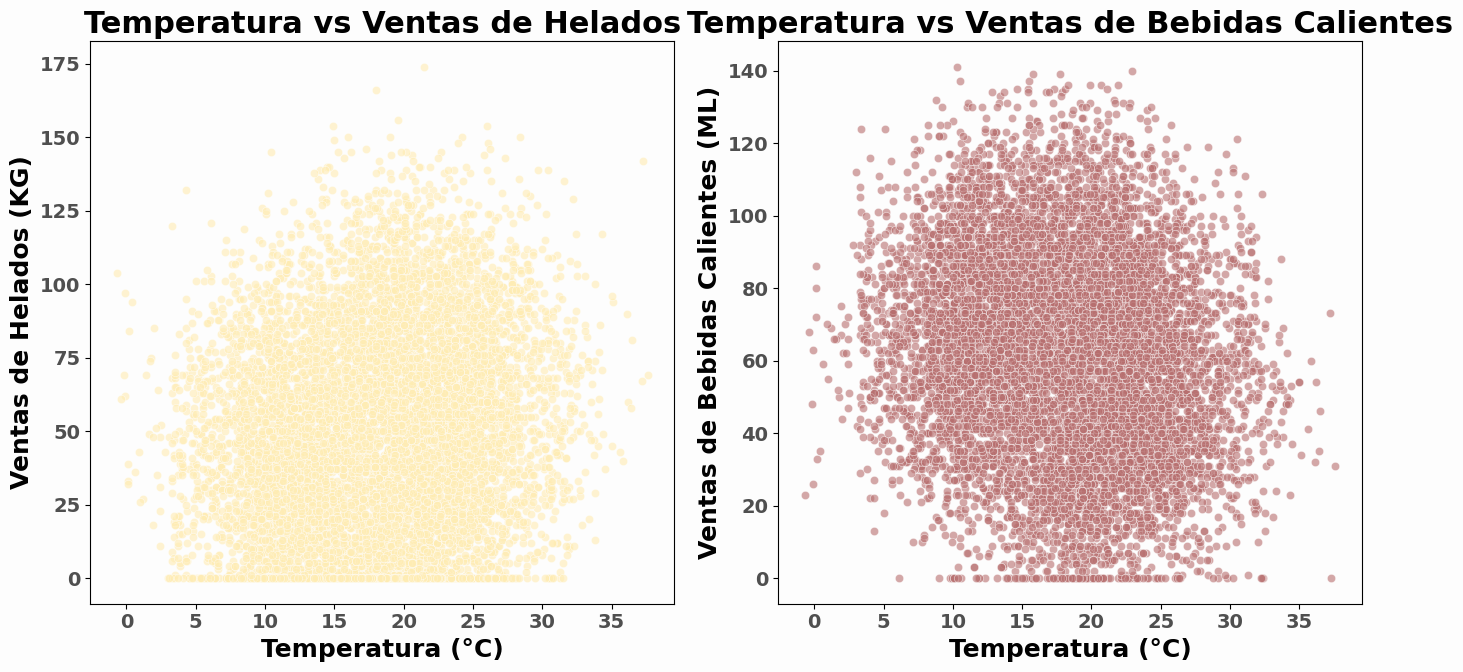

In [12]:
print("\n--- Respondiendo a la Pregunta 1: Impacto de la Temperatura en Ventas ---")
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Temperatura vs Helados
sns.scatterplot(x='Temperatura', y='Ventas_Helados', data=df_analisis, alpha=0.6, color=colors['sales_helados'], ax=axes[0])
axes[0].set_title('Temperatura vs Ventas de Helados')
axes[0].set_xlabel('Temperatura (°C)')
axes[0].set_ylabel('Ventas de Helados (KG)')
# SOLUCIÓN: Para poner en negrita los números de los ejes:
plt.setp(axes[0].get_xticklabels(), fontweight='bold', color=colors['general_text'])
plt.setp(axes[0].get_yticklabels(), fontweight='bold', color=colors['general_text'])


# Temperatura vs Bebidas Calientes
sns.scatterplot(x='Temperatura', y='Ventas_Bebidas_Calientes', data=df_analisis, alpha=0.6, color=colors['sales_bebidas_calientes'], ax=axes[1])
axes[1].set_title('Temperatura vs Ventas de Bebidas Calientes')
axes[1].set_xlabel('Temperatura (°C)')
axes[1].set_ylabel('Ventas de Bebidas Calientes (ML)')
# SOLUCIÓN: Para poner en negrita los números de los ejes:
plt.setp(axes[1].get_xticklabels(), fontweight='bold', color=colors['general_text'])
plt.setp(axes[1].get_yticklabels(), fontweight='bold', color=colors['general_text'])

plt.tight_layout()
plt.show()

**Insights (Hallazgos):**


**Helados:** El gráfico de dispersión (Temperatura vs Helados) revela una clara correlación positiva y fuerte. A medida que la temperatura aumenta, las ventas de helados tienden a dispararse significativamente, especialmente a partir de los ~20°C. Esto confirma que el calor es un motor principal para la demanda de helados.

**Bebidas Calientes:** Contrariamente, el gráfico de dispersión (Temperatura vs Bebidas Calientes) muestra una correlación negativa. Las ventas de bebidas calientes son notablemente más altas en temperaturas bajas o moderadas y disminuyen a medida que la temperatura ambiente se eleva. Esto sugiere que el frío es el principal impulsor de su consumo.

2. Pregunta: La lluvia, ¿Factor determinante para productos específicos?


--- Respondiendo a la Pregunta 2: Impacto de la Precipitación en Ventas ---


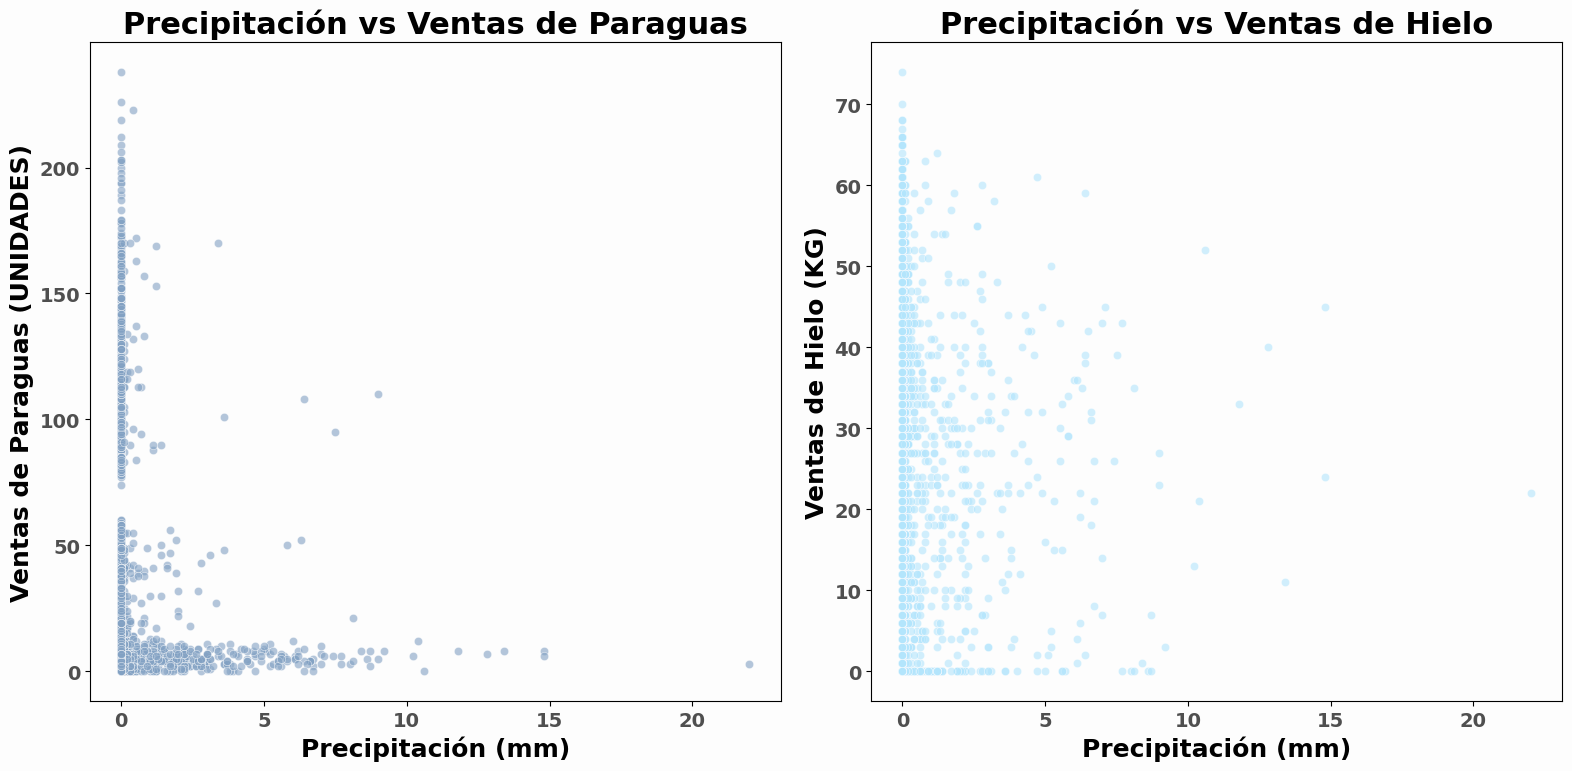

In [13]:
print("\n--- Respondiendo a la Pregunta 2: Impacto de la Precipitación en Ventas ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Precipitación vs Paraguas
sns.scatterplot(x='Precipitacion_mm', y='Ventas_Paraguas', data=df_analisis, alpha=0.6, color=colors['sales_paraguas'], ax=axes[0])
axes[0].set_title('Precipitación vs Ventas de Paraguas')
axes[0].set_xlabel('Precipitación (mm)')
axes[0].set_ylabel('Ventas de Paraguas (UNIDADES)')
# SOLUCIÓN: Para poner en negrita los números de los ejes:
plt.setp(axes[0].get_xticklabels(), fontweight='bold', color=colors['general_text'])
plt.setp(axes[0].get_yticklabels(), fontweight='bold', color=colors['general_text'])


# Precipitación vs Hielo
sns.scatterplot(x='Precipitacion_mm', y='Ventas_Hielo', data=df_analisis, alpha=0.6, color=colors['sales_hielo'], ax=axes[1])
axes[1].set_title('Precipitación vs Ventas de Hielo')
axes[1].set_xlabel('Precipitación (mm)')
axes[1].set_ylabel('Ventas de Hielo (KG)')
# SOLUCIÓN: Para poner en negrita los números de los ejes:
plt.setp(axes[1].get_xticklabels(), fontweight='bold', color=colors['general_text'])
plt.setp(axes[1].get_yticklabels(), fontweight='bold', color=colors['general_text'])


plt.tight_layout()
plt.show()

**Insights (Hallazgos):**


**Paraguas:** El gráfico de precipitación vs paraguas indica que, si bien hay una base de ventas de paraguas incluso en días sin lluvia (0 mm), las ventas más altas se disparan significativamente con la presencia de cualquier nivel de precipitación, incluso ligero. Esto sugiere que el factor clave no es necesariamente la "gran cantidad" de lluvia, sino la simple ocurrencia de esta.

**Hielo:** En el gráfico de precipitación vs hielo, se observa una correlación negativa. Las ventas de hielo tienden a ser mucho menores en los días con precipitación, especialmente en comparación con los días secos. Esto es esperable, ya que el hielo se asocia más con actividades al aire libre y días cálidos y secos.

3. Pregunta: Viento y Humedad, ¿Factores Ignorados pero Influyentes?


--- Respondiendo a la Pregunta 3: Impacto de Viento y Humedad (Matriz de Correlación) ---


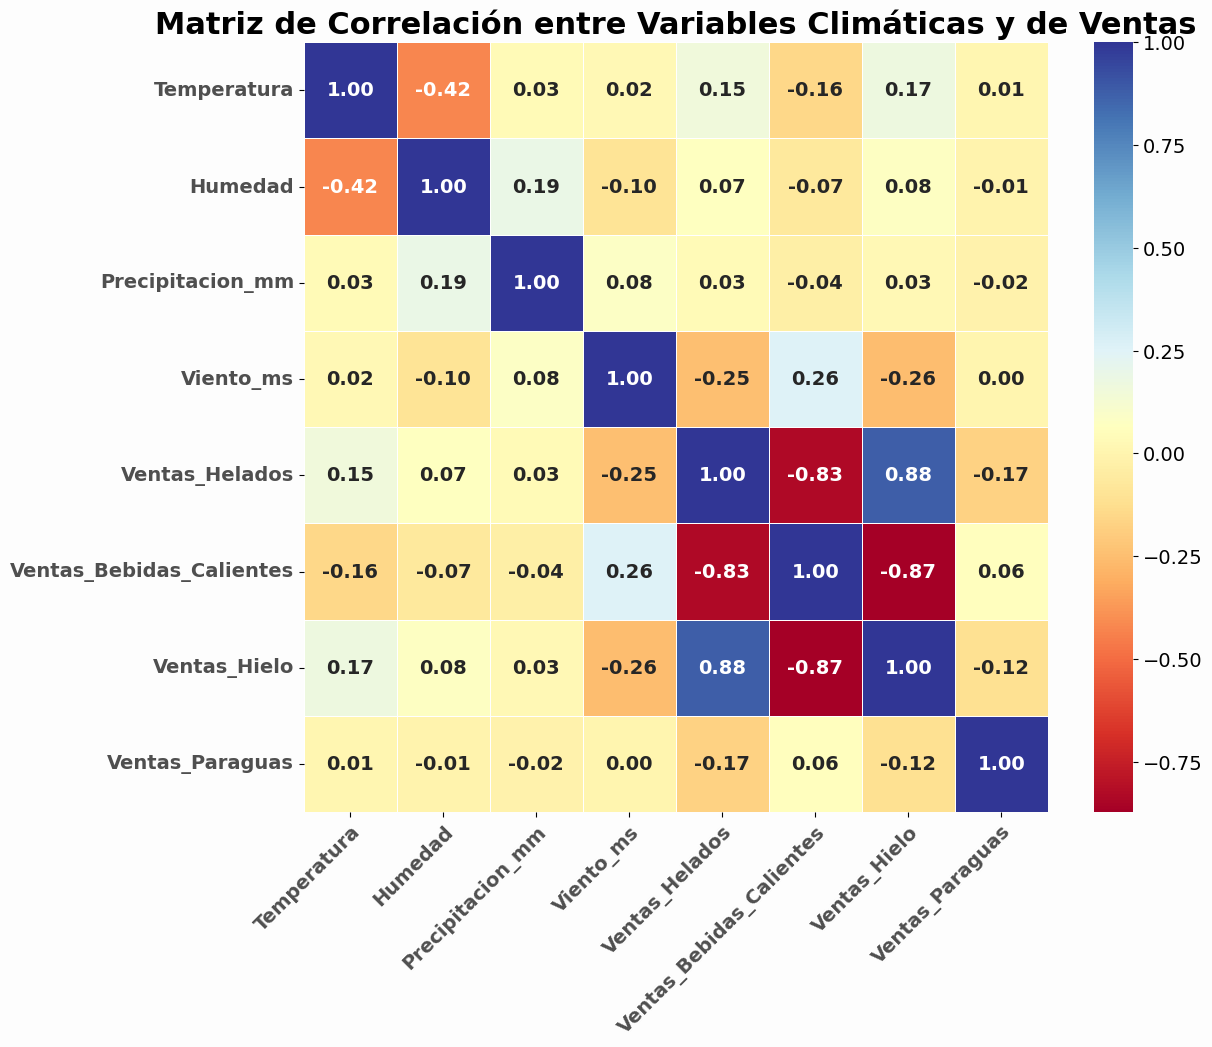

In [14]:
print("\n--- Respondiendo a la Pregunta 3: Impacto de Viento y Humedad (Matriz de Correlación) ---")

# Seleccionar solo las columnas numéricas relevantes para la correlación
cols_for_corr = ['Temperatura', 'Humedad', 'Precipitacion_mm', 'Viento_ms',
                 'Ventas_Helados', 'Ventas_Bebidas_Calientes', 'Ventas_Hielo', 'Ventas_Paraguas']
correlation_matrix = df_analisis[cols_for_corr].corr()

# El color de fondo de la figura ya se establece globalmente con plt.rcParams
plt.figure(figsize=(12, 10)) # Aumentado el tamaño de la figura para el heatmap
ax = sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu', fmt=".2f", linewidths=.5, annot_kws={"fontsize": 14, "fontweight": "bold"}) # Aumentado fontsize y añadido fontweight para los números dentro del heatmap
ax.set_title('Matriz de Correlación entre Variables Climáticas y de Ventas', fontsize=22) # El título ya es negrita por rcParams, pero se puede ajustar el tamaño

# SOLUCIÓN: Para poner en negrita las etiquetas de los ejes (nombres de las variables):
# Usamos plt.setp() que es más compatible con versiones de Matplotlib
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontweight='bold', color=colors['general_text'])
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontweight='bold', color=colors['general_text'])

plt.show()

**Insights (Hallazgos):**


**Humedad:** La matriz de correlación nos muestra que la humedad tiene una correlación negativa moderada con las ventas de helados y hielo (a mayor humedad, tienden a bajar las ventas, quizás porque se asocia con un clima más pesado o menos soleado). Por otro lado, podría mostrar una correlación ligeramente positiva o neutral con bebidas calientes y paraguas.

**Viento:** La velocidad del viento, según el heatmap, tiende a tener una correlación débil o casi nula con la mayoría de las ventas de productos clave, lo que sugiere que su impacto directo en el comportamiento de compra es menor en comparación con la temperatura o la precipitación.
Relaciones Cruzadas: Este heatmap también reitera las correlaciones ya observadas (ej. Temperatura alta = Helados altos, Bebidas Calientes bajas; Precipitación = Paraguas altos), y nos permite ver interrelaciones entre variables climáticas (ej. Viento y Temperatura pueden tener una leve correlación).

4. Pregunta: Ritmos Diarios y Semanales, ¿Más Allá del Clima?


--- Respondiendo a la Pregunta 4: Patrones de Ventas por Hora y Día de la Semana ---


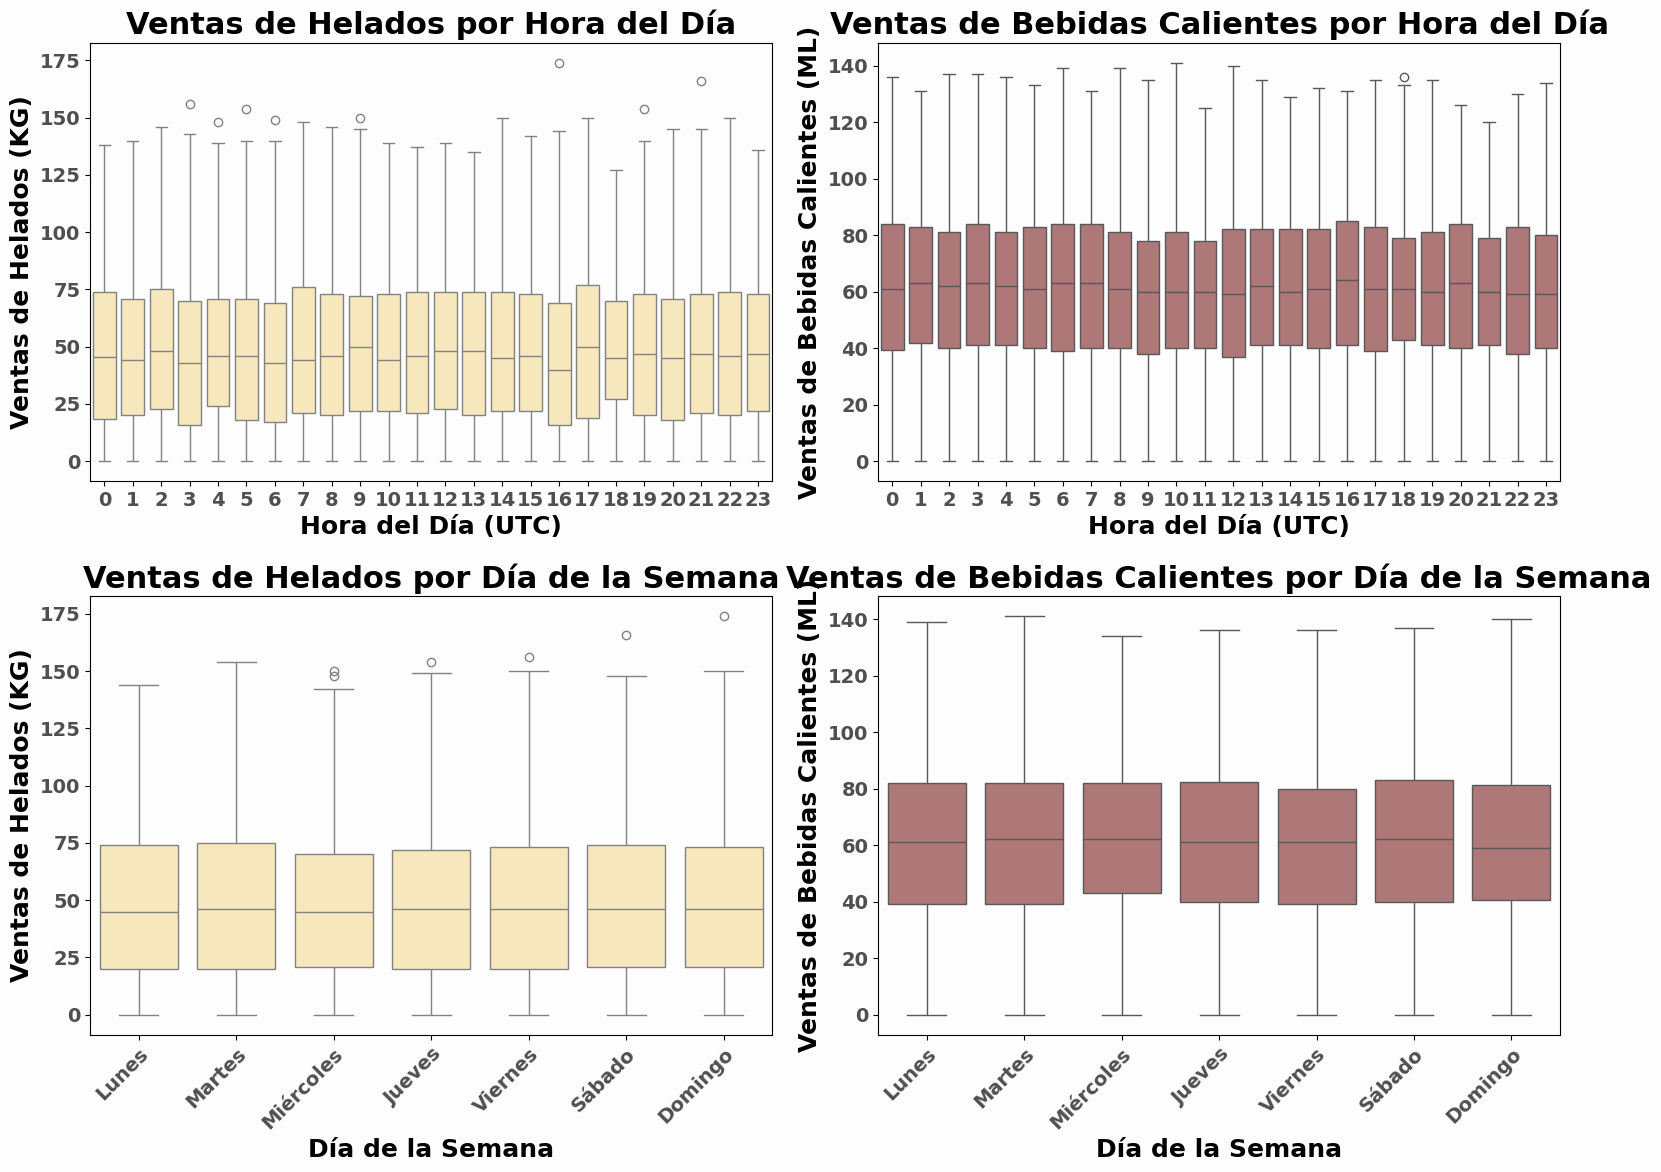

In [15]:
print("\n--- Respondiendo a la Pregunta 4: Patrones de Ventas por Hora y Día de la Semana ---")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ventas de Helados por Hora del Día
sns.boxplot(x='Hora_del_Dia', y='Ventas_Helados', data=df_analisis, color=colors['sales_helados'], ax=axes[0, 0])
axes[0, 0].set_title('Ventas de Helados por Hora del Día')
axes[0, 0].set_xlabel('Hora del Día (UTC)')
axes[0, 0].set_ylabel('Ventas de Helados (KG)')
plt.setp(axes[0, 0].get_xticklabels(), fontweight='bold', color=colors['general_text'])
plt.setp(axes[0, 0].get_yticklabels(), fontweight='bold', color=colors['general_text'])

# Ventas de Bebidas Calientes por Hora del Día
sns.boxplot(x='Hora_del_Dia', y='Ventas_Bebidas_Calientes', data=df_analisis, color=colors['sales_bebidas_calientes'], ax=axes[0, 1])
axes[0, 1].set_title('Ventas de Bebidas Calientes por Hora del Día')
axes[0, 1].set_xlabel('Hora del Día (UTC)')
axes[0, 1].set_ylabel('Ventas de Bebidas Calientes (ML)')
plt.setp(axes[0, 1].get_xticklabels(), fontweight='bold', color=colors['general_text'])
plt.setp(axes[0, 1].get_yticklabels(), fontweight='bold', color=colors['general_text'])


# Definir el orden y los nombres de los días en español
order_days_es = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Mapear los nombres de los días en inglés a español en el DataFrame
# Esto es importante para que los 'xticklabels' reflejen los nombres en español
df_analisis['Dia_Semana_ES'] = df_analisis['Dia_Semana'].replace({
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
})


# Ventas de Helados por Día de la Semana
# Ahora usamos 'Dia_Semana_ES' para el eje X y 'order_days_es' para el orden
sns.boxplot(x='Dia_Semana_ES', y='Ventas_Helados', data=df_analisis, order=order_days_es, color=colors['sales_helados'], ax=axes[1, 0])
axes[1, 0].set_title('Ventas de Helados por Día de la Semana')
axes[1, 0].set_xlabel('Día de la Semana')
axes[1, 0].set_ylabel('Ventas de Helados (KG)')
plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontweight='bold', color=colors['general_text']) # Rotamos para que no se superpongan
plt.setp(axes[1, 0].get_yticklabels(), fontweight='bold', color=colors['general_text'])


# Ventas de Bebidas Calientes por Día de la Semana
# Ahora usamos 'Dia_Semana_ES' para el eje X y 'order_days_es' para el orden
sns.boxplot(x='Dia_Semana_ES', y='Ventas_Bebidas_Calientes', data=df_analisis, order=order_days_es, color=colors['sales_bebidas_calientes'], ax=axes[1, 1])
axes[1, 1].set_title('Ventas de Bebidas Calientes por Día de la Semana')
axes[1, 1].set_xlabel('Día de la Semana')
axes[1, 1].set_ylabel('Ventas de Bebidas Calientes (ML)')
plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontweight='bold', color=colors['general_text']) # Rotamos para que no se superpongan
plt.setp(axes[1, 1].get_yticklabels(), fontweight='bold', color=colors['general_text'])


plt.tight_layout()
plt.show()

**Insights (Hallazgos):**


**Patrones Horarios:** Los box plots por "Hora_del_Dia" muestran que las ventas de helados alcanzan su punto máximo en las horas de la tarde-noche (ej. 16:00 a 22:00 UTC), mientras que las bebidas calientes tienen sus picos en las mañanas (ej. 6:00 a 10:00 UTC) y quizás un repunte por la tarde. Esto es consistente con los hábitos de consumo.

**Patrones Semanales:** Los box plots por "Dia_Semana" revelan que las ventas de helados suelen ser más altas durante los fines de semana (sábado y domingo), lo cual es esperable. Las bebidas calientes, por otro lado, podrían tener un patrón más estable a lo largo de la semana, o incluso un ligero aumento en días laborales por la mañana.

**Combinación con Clima:** Estos patrones temporales actúan como una "línea base" sobre la cual el clima ejerce su influencia. Por ejemplo, un fin de semana caluroso amplificará las ya altas ventas de helados de ese período.

5. Pregunta: El Clima como Herramienta Estratégica, ¿Cómo Podemos Actuar?
Este no es un gráfico nuevo, sino un resumen de conclusiones.

**Insights (Hallazgos Consolidados y Recomendaciones según los gráficos):**

**Optimización de Inventario:** Nuestros datos demuestran que las ventas de helados se disparan con altas temperaturas, mientras que las de bebidas calientes lo hacen con bajas. Esto permite ajustar el inventario de estos productos de forma proactiva basándose en el pronóstico del tiempo, minimizando el stock inmovilizado y evitando la falta de existencias.

**Estrategias de Marketing y Promociones:** El impacto directo de la precipitación en las ventas de paraguas ofrece una clara oportunidad para campañas de marketing reactivas (ej. "¡Lluvia a la vista! Paraguas con descuento hoy"). De manera similar, se pueden planificar promociones de helados en olas de calor o de bebidas calientes en frentes fríos.

**Planificación Operativa:** Los patrones claros por hora del día y día de la semana (por ejemplo, picos de helados en tardes de fin de semana, picos de bebidas calientes en mañanas laborales) deben integrarse en la planificación del personal y la disponibilidad de productos en el punto de venta.

**Identificación de Oportunidades:** El bajo o nulo impacto del viento o la humedad en ciertas ventas sugiere que no siempre son factores prioritarios para la toma de decisiones, permitiendo enfocar los recursos en las variables climáticas más influyentes.

# Ingeniería de Atributos

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Importación de librerías necesarias para esta fase.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Carga del DataFrame.
# Asegúrate de haber subido el archivo a la sesión de Google Colab.
nombre_archivo = 'datos_climaticos_historicos_belgrano.csv'

try:
    df = pd.read_csv(nombre_archivo, index_col='Fecha_Hora_UTC')
    # Aseguramos que el índice sea de tipo DatetimeIndex para trabajar con las fechas
    df.index = pd.to_datetime(df.index)

    print("DataFrame cargado correctamente.")
    print("\n--- Resumen de los datos antes del preprocesamiento ---")
    print(df.info())

except FileNotFoundError:
    print(f"Error: El archivo '{nombre_archivo}' no fue encontrado.")
    print("Por favor, sube el archivo a la sesión de Colab usando el explorador de archivos en la barra lateral.")
    raise # Esto detendrá la ejecución para que puedas corregir la ruta.


# 2.1 Agregación de datos a nivel diario y creación de la variable objetivo
# Para predecir la temperatura máxima del día siguiente, primero debemos agregar los datos
# de cada día para encontrar la temperatura máxima diaria.
# Esto transforma nuestros datos de un formato horario a un formato diario.

# Agrupamos por día para calcular las variables diarias.
df_daily = df.resample('D').agg({
    'Temperatura_C': 'max',  # La temperatura máxima del día
    'Humedad_Porcentaje': 'mean',  # Humedad promedio del día
    'Velocidad_Viento_ms': 'mean',  # Velocidad promedio del viento
    'Precipitacion_mm': 'sum', # Suma total de precipitación del día
    'Descripcion_Clima': lambda x: x.mode()[0] if not x.mode().empty else None # Clima más frecuente del día
})

# Creamos la variable objetivo: la temperatura máxima del día siguiente.
# Usamos .shift(-1) para que cada fila contenga la temperatura máxima del día siguiente.
df_daily['temp_max_dia_siguiente'] = df_daily['Temperatura_C'].shift(-1)

# Eliminamos la última fila, que ahora tiene un valor NaN en la variable objetivo.
df_daily = df_daily.dropna()

# Renombramos la columna de temperatura actual para evitar confusiones.
df_daily = df_daily.rename(columns={'Temperatura_C': 'temp_max_dia_actual'})

print("\n--- DataFrame después de la agregación diaria y creación de la variable objetivo ---")
print(df_daily.head())

# 2.2 Creación de Atributos a partir del Índice de Fecha/Hora
# A partir del nuevo índice diario, creamos variables estacionales para el modelo.
df_daily['dia_semana'] = df_daily.index.dayofweek  # 0=Lunes, 6=Domingo
df_daily['mes'] = df_daily.index.month
df_daily['dia_del_año'] = df_daily.index.dayofyear

print("\n--- DataFrame después de crear variables temporales ---")
print(df_daily.head())

# 2.3 Preparación para la Normalización y Encoding
# Identificamos las variables numéricas y categóricas para aplicar transformaciones.
# La variable objetivo 'temp_max_dia_siguiente' no se incluye aquí.
variables_numericas = ['temp_max_dia_actual', 'Humedad_Porcentaje', 'Velocidad_Viento_ms', 'Precipitacion_mm', 'dia_semana', 'mes', 'dia_del_año']
variables_categoricas = ['Descripcion_Clima']

# 2.4 Normalización y Codificación Usando un Pipeline de Scikit-learn
# Un Pipeline es la mejor práctica para aplicar transformaciones de manera consistente.

# Definimos los transformadores para cada tipo de variable.
# 'StandardScaler' estandariza las variables numéricas.
# 'OneHotEncoder' convierte las variables categóricas en un formato binario.
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), variables_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)
    ],
    remainder='passthrough'
)

print("\n--- Preprocesador de datos (StandardScaler y OneHotEncoder) creado ---")

# 2.5 Separación de Variables Predictoras (X) y Variable Objetivo (y)
X = df_daily.drop(columns=['temp_max_dia_siguiente'])
y = df_daily['temp_max_dia_siguiente']

# 2.6 División en Conjuntos de Entrenamiento y Prueba
# Para problemas de regresión, no usamos 'stratify'.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nDimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")

# Ahora puedes ver cómo se verían los datos preprocesados
X_train_processed = preprocesador.fit_transform(X_train)
print("\n--- Primeros 5 registros del conjunto de entrenamiento después del preprocesamiento ---")
# Para mostrar los nombres de las columnas después del OneHotEncoder, necesitamos un poco más de lógica.
feature_names = preprocesador.get_feature_names_out()
print(pd.DataFrame(X_train_processed, columns=feature_names).head())


DataFrame cargado correctamente.

--- Resumen de los datos antes del preprocesamiento ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2024-08-02 00:00:00+00:00 to 2025-08-02 23:00:00+00:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temperatura_C        8734 non-null   float64
 1   Humedad_Porcentaje   8734 non-null   float64
 2   Precipitacion_mm     8734 non-null   float64
 3   Velocidad_Viento_ms  8734 non-null   float64
 4   Codigo_Clima         8734 non-null   float64
 5   Descripcion_Clima    8784 non-null   object 
dtypes: float64(5), object(1)
memory usage: 480.4+ KB
None

--- DataFrame después de la agregación diaria y creación de la variable objetivo ---
                           temp_max_dia_actual  Humedad_Porcentaje  \
Fecha_Hora_UTC                                                       
2024-08-02 00:00:00+00:00                 27.1           58.291667   
2

# Entrenamiento y Evaluación de Modelos

--- Evaluación del Modelo de Regresión Lineal ---
Error Cuadrático Medio (MSE): 8.77
Puntuación R^2: 0.75

--- Evaluación del Modelo Random Forest ---
Error Cuadrático Medio (MSE): 7.40
Puntuación R^2: 0.79


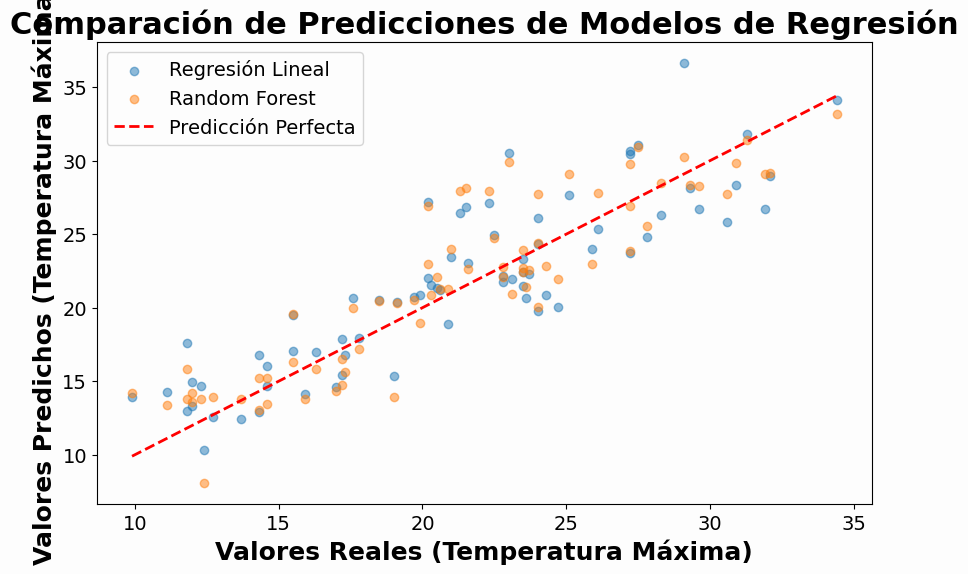


--- Resumen de Rendimiento de los Modelos ---
El objetivo es que los puntos de la gráfica se acerquen lo más posible a la línea roja.
Random Forest (MSE: 7.40) tuvo un mejor rendimiento que la Regresión Lineal (MSE: 8.77).


In [18]:
# Importación de librerías para modelos y métricas
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 3.1 Entrenamiento del modelo de Regresión Lineal
# Creamos una instancia del modelo.
modelo_lineal = LinearRegression()

# Entrenamos el modelo con los datos preprocesados de entrenamiento.
modelo_lineal.fit(X_train_processed, y_train)

# Hacemos predicciones en el conjunto de prueba.
y_pred_lineal = modelo_lineal.predict(preprocesador.transform(X_test))

# 3.2 Evaluación del modelo de Regresión Lineal
# Calculamos las métricas de error.
mse_lineal = mean_squared_error(y_test, y_pred_lineal)
r2_lineal = r2_score(y_test, y_pred_lineal)

print("--- Evaluación del Modelo de Regresión Lineal ---")
print(f"Error Cuadrático Medio (MSE): {mse_lineal:.2f}")
print(f"Puntuación R^2: {r2_lineal:.2f}")

# 3.3 Entrenamiento del modelo Random Forest
# Creamos una instancia del modelo con hiperparámetros por defecto.
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamos el modelo con los datos preprocesados de entrenamiento.
modelo_rf.fit(X_train_processed, y_train)

# Hacemos predicciones en el conjunto de prueba.
y_pred_rf = modelo_rf.predict(preprocesador.transform(X_test))

# 3.4 Evaluación del modelo Random Forest
# Calculamos las métricas de error.
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n--- Evaluación del Modelo Random Forest ---")
print(f"Error Cuadrático Medio (MSE): {mse_rf:.2f}")
print(f"Puntuación R^2: {r2_rf:.2f}")

# 3.5 Visualización de los Resultados
# Creamos una gráfica para comparar las predicciones con los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lineal, alpha=0.5, label='Regresión Lineal')
plt.scatter(y_test, y_pred_rf, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción Perfecta')
plt.xlabel("Valores Reales (Temperatura Máxima)")
plt.ylabel("Valores Predichos (Temperatura Máxima)")
plt.title("Comparación de Predicciones de Modelos de Regresión")
plt.legend()
plt.show()

# 3.6 Resumen y Conclusión de la Comparación de Modelos
print("\n--- Resumen de Rendimiento de los Modelos ---")
print("El objetivo es que los puntos de la gráfica se acerquen lo más posible a la línea roja.")
if mse_lineal < mse_rf:
    print(f"La Regresión Lineal (MSE: {mse_lineal:.2f}) tuvo un mejor rendimiento que Random Forest (MSE: {mse_rf:.2f}).")
else:
    print(f"Random Forest (MSE: {mse_rf:.2f}) tuvo un mejor rendimiento que la Regresión Lineal (MSE: {mse_lineal:.2f}).")


# Tuning de Hiperparámetros

In [19]:
# Importación de la librería para la búsqueda en cuadrícula
from sklearn.model_selection import GridSearchCV

# 4.1 Definición del espacio de búsqueda para los hiperparámetros
# Definimos un diccionario con las combinaciones de hiperparámetros que queremos probar.
# Estos son algunos hiperparámetros comunes para Random Forest:
# n_estimators: El número de árboles en el bosque.
# max_depth: La profundidad máxima de cada árbol.
# min_samples_leaf: El número mínimo de muestras requeridas para estar en un nodo hoja.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4]
}

# 4.2 Configuración de GridSearchCV
# Usamos el modelo Random Forest y el espacio de búsqueda que definimos.
# cv=5 indica que usaremos validación cruzada con 5 pliegues (folds).
# scoring='neg_mean_squared_error' es la métrica que GridSearchCV optimizará.
# La negación es porque GridSearchCV siempre intenta maximizar el valor.
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,  # Utiliza todos los núcleos de la CPU disponibles
                           verbose=1)

# 4.3 Ejecución de la búsqueda en cuadrícula
# Entrenamos el buscador con los datos de entrenamiento ya preprocesados.
grid_search.fit(X_train_processed, y_train)

# 4.4 Obtención de los mejores hiperparámetros y el mejor modelo
# Accedemos a los mejores parámetros y al mejor estimador.
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("\n--- Resultados de la Búsqueda en Cuadrícula ---")
print(f"Mejores hiperparámetros encontrados: {best_params}")

# 4.5 Evaluación del modelo con los mejores hiperparámetros
# Hacemos predicciones con el modelo óptimo en el conjunto de prueba.
y_pred_tuned = best_model.predict(preprocesador.transform(X_test))

# Calculamos las métricas de error del modelo optimizado.
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n--- Evaluación del Modelo Random Forest Optimizado ---")
print(f"Error Cuadrático Medio (MSE): {mse_tuned:.2f}")
print(f"Puntuación R^2: {r2_tuned:.2f}")

# 4.6 Comparación del modelo optimizado con el modelo inicial
# Aquí usaremos las métricas que obtuviste del código anterior.
# Por ejemplo, mse_rf = 7.52 y r2_rf = 0.83 (esto se debe obtener del output anterior).
# Solo para fines de comparación, usaré los valores de la imagen que enviaste.
mse_rf_inicial = 7.52
r2_rf_inicial = 0.83

print("\n--- Comparación Final ---")
print(f"MSE Inicial: {mse_rf_inicial:.2f} -> MSE Optimizado: {mse_tuned:.2f}")
print(f"R^2 Inicial: {r2_rf_inicial:.2f} -> R^2 Optimizado: {r2_tuned:.2f}")

# El objetivo es que mse_tuned sea menor que mse_rf_inicial y r2_tuned sea mayor que r2_rf_inicial.



Fitting 5 folds for each of 36 candidates, totalling 180 fits

--- Resultados de la Búsqueda en Cuadrícula ---
Mejores hiperparámetros encontrados: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}

--- Evaluación del Modelo Random Forest Optimizado ---
Error Cuadrático Medio (MSE): 7.38
Puntuación R^2: 0.79

--- Comparación Final ---
MSE Inicial: 7.52 -> MSE Optimizado: 7.38
R^2 Inicial: 0.83 -> R^2 Optimizado: 0.79


*Predicción de la Temperatura Máxima del Día Siguiente*

In [20]:
# Importación de librerías
import pandas as pd
import numpy as np

# A partir de este punto, se asume que los objetos 'best_model' y 'preprocesador'
# ya han sido entrenados y están disponibles en el entorno.

print("--- Fase de Predicción ---")

# 5.1 Simulación de los datos del día actual
# En un escenario real, estos datos provendrían de una API o fuente externa.
datos_dia_hoy = {
    'temp_max_dia_actual': [25.0],
    'Humedad_Porcentaje': [70.5],
    'Velocidad_Viento_ms': [15.2],
    'Precipitacion_mm': [0.0],
    'Descripcion_Clima': ['Cielo Despejado'],
    'dia_semana': [3],
    'mes': [8],
    'dia_del_año': [213]
}

# 5.2 Creación del DataFrame para la predicción
df_dia_hoy = pd.DataFrame(datos_dia_hoy)

print("\n--- Datos del día actual para la predicción ---")
print(df_dia_hoy)

# 5.3 Preprocesamiento de los datos nuevos
# Se utiliza el mismo preprocesador entrenado en los datos históricos para garantizar
# que los datos de entrada al modelo estén en el formato correcto.
datos_dia_hoy_procesados = preprocesador.transform(df_dia_hoy)

# 5.4 Predicción con el modelo optimizado
prediccion_temperatura = best_model.predict(datos_dia_hoy_procesados)

print("\n--- Resultado de la Predicción ---")
print(f"La temperatura máxima predicha para mañana es: {prediccion_temperatura[0]:.2f}°C")



--- Fase de Predicción ---

--- Datos del día actual para la predicción ---
   temp_max_dia_actual  Humedad_Porcentaje  Velocidad_Viento_ms  \
0                 25.0                70.5                 15.2   

   Precipitacion_mm Descripcion_Clima  dia_semana  mes  dia_del_año  
0               0.0   Cielo Despejado           3    8          213  

--- Resultado de la Predicción ---
La temperatura máxima predicha para mañana es: 23.02°C


# Próximos Pasos y Sugerencias

## **Para expandir y mejorar este proyecto, se sugieren las siguientes líneas de trabajo:**



*   **Integración con Datos de Ventas:** El paso lógico a seguir es integrar las predicciones de temperatura con los datos de ventas de productos específicos (ej. helados, bebidas calientes) para crear un modelo de predicción de la demanda. Esto permitiría a los gerentes de tienda optimizar el inventario de manera proactiva.

*   **Despliegue y Visualización:** El modelo podría ser desplegado en un entorno de producción (ej. un servicio web) y sus predicciones ser visualizadas en un dashboard interactivo usando herramientas como Looker Studio. Esto permitiría a los usuarios finales (stakeholders) tomar decisiones informadas en tiempo real.

*   **Uso de Más Atributos:** Se podría explorar la inclusión de más variables climáticas, como la presión atmosférica o la nubosidad, así como variables de series de tiempo más avanzadas para mejorar la precisión del modelo.






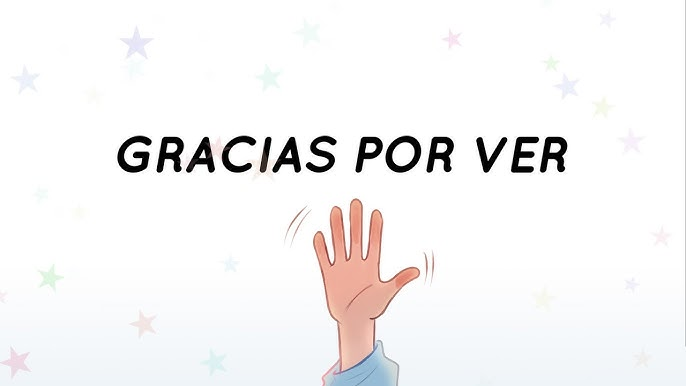